# Q4) 
Create two t-contrast brain map plots (see Figure 5.9 in your textbook) for each condition (eyes open and eyes closed). This involves fitting a GLM model for every voxel in the dataset. Discuss your results.
Hint: Check out the Nilearn plot surf stat map function. https://nilearn.github.io/stable/auto_examples/01_plotting/plot_3d_map_to_surface_projection.html#making-a-surface-plot-of-a-3d-statistical-map

In [ ]:
# Import the requred Packages
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib

fmri_file = '../../datasets/fMRI/HW4/sub-001_ses-001_task-eoec_bold.nii.gz' # Get the nifti file (fMRI)
img = nib.load(fmri_file) # Load in the nifti file (fMRI)

mri_file = '../../datasets/fMRI/HW4/sub-001_ses-001_acq-highres_T1w.nii.gz' # Get the nifti file (MRI)
background_img = nib.load(mri_file) # Load in the nifti file (MRI)

## The Predictors

The numbers used in the predictiors came from the content in the tsv file.

In [2]:
# TSV File content

# onset	duration	trial_type
# 0	20	EC
# 20	20	EO
# 40	20	EC
# 60	20	EO
# 80	20	EC
# 100	20	EO
# 120	20	EC
# 140	20	EO
# 160	20	EC
# 180	20	EO
# 200	20	EC
# 220	20	EO

# Timepoints (assuming 1-second TR, adjust as necessary)
n_timepoints = 240  # Total timepoints
time = np.arange(n_timepoints)

# Create binary regressors
design_EC = np.zeros(n_timepoints)
design_EO = np.zeros(n_timepoints)


# Populate ranges based on TSV file
design_EC[0:20] = -1 # Set the value of first occurance of Eye Closed
design_EC[40:60] = -1 # Set the value of second occurance of Eye Closed
design_EC[80:100] = -1 # Set the value of third occurance of Eye Closed
design_EC[120:140] = -10 # Set the value of fourth occurance of Eye Closed
design_EC[160:180] = -15 # Set the value of fifth occurance of Eye Closed
design_EC[200:220] = -10 # Set the value of sixth occurance of Eye Closed

design_EO[20:40] = 20 # Set the value of first occurance of Eye Open
design_EO[60:80] = 15 # Set the value of second occurance of Eye Open
design_EO[100:120] = 20 # Set the value of third occurance of Eye Open
design_EO[140:160] = 10 # Set the value of fourth occurance of Eye Open
design_EO[180:200] = 10 # Set the value of fifth occurance of Eye Open
design_EO[220:240] = 10 # Set the value of sixth occurance of Eye Open


design_EO_downsampled = design_EO.reshape(-1, 2).mean(axis=1) # Downsample the eyes open vector
design_EC_downsampled = design_EC.reshape(-1, 2).mean(axis=1) # Downsample the eyes open vector

## GLM Application to Every Voxel Signal

Given two events (eyes open & eyes closed) which are now associated to 2 GLM models (Q2 and Q3), we will now plot them in every voxel to try and see if we can find anything meaningful. With this we will also plot Q2 and Q3 just to see any general differences between the two that we didn't see in the analysis of Q3.

### Plot details

Firstly the threshold was set to 5 to cut out any loosely corralated voxel signals to more accurately show high corralation voxel signals. Second, the background image of the plot takes the MRI image and maps the fMRI results onto that map to better see what's going on and where in a high resolution.


---

## Plot Q2 Eyes Open & Eyes Closed GLMs (no HRF) results to all rMRI data.

/tmp/ipykernel_389692/212898104.py:43: RuntimeWarning: invalid value encountered in scalar divide
  t_map_EO[x, y, z] = (contrast_EO @ beta) / np.sqrt(residual_var * (contrast_EO @ np.linalg.inv(design_matrix.T @ design_matrix) @ contrast_EO)) # Get t-test result for eyes open
/tmp/ipykernel_389692/212898104.py:44: RuntimeWarning: invalid value encountered in scalar divide
  t_map_EC[x, y, z] = (contrast_EC @ beta) / np.sqrt(residual_var * (contrast_EC @ np.linalg.inv(design_matrix.T @ design_matrix) @ contrast_EC)) # Get t-test result for eyes closed


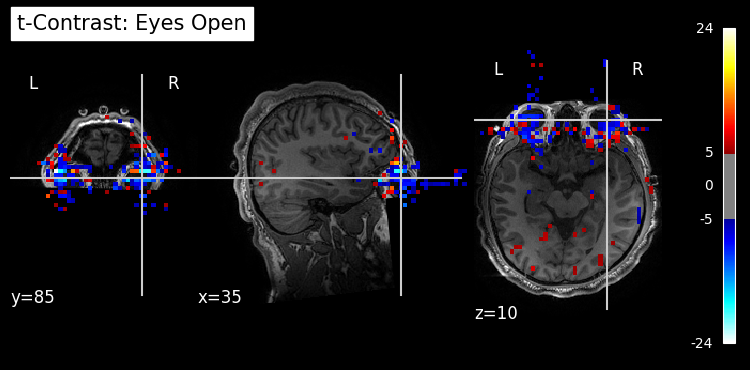

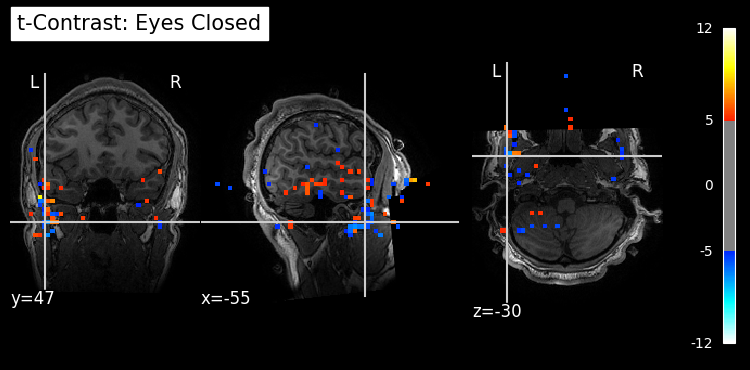

In [ ]:
# Import more libraries to plot changes
import numpy as np
import nibabel as nib
from nilearn.image import resample_to_img, new_img_like
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_stat_map
from nilearn.glm.first_level import run_glm
from nilearn.glm.contrasts import compute_contrast

icept = np.ones((design_EC_downsampled.size, 1)) # Generate template for intercepts

# Combine Eyes Open and Eyes Closed regressors
design_matrix = np.column_stack([icept, design_EO_downsampled, design_EC_downsampled])

# Fit GLM to each voxel
data = img.get_fdata()
shape = data.shape[:-1]  # Exclude time dimension
beta_maps = np.zeros((*shape, 3))  # Now accounting for three predictors

for x in range(shape[0]): # Loop through x axis
    for y in range(shape[1]): # Loop through y axis
        for z in range(shape[2]): # Loop through z axis
            voxel_signal = data[x, y, z, :] # Grab voxel signal
            if np.any(voxel_signal): # Check if the voxel signal is valid
                betas_simple = np.linalg.inv(design_matrix.T @ design_matrix) @ design_matrix.T @ voxel_signal # Calculate the betas for the simple model
                beta_maps[x, y, z, :] = betas_simple # Put the betas into same voxel position

# Contrasts
contrast_EO = np.array([0, 1, 0])
contrast_EC = np.array([0, 0, 1])

# Compute t-maps
t_map_EO = np.zeros(shape)
t_map_EC = np.zeros(shape)


for x in range(shape[0]): # Loop through x axis
    for y in range(shape[1]): # Loop through y axis
        for z in range(shape[2]): # Loop through z axis
            beta = beta_maps[x, y, z, :] # Grab beta vector for a given voxel
            residual_var = np.sum((data[x, y, z, :] - design_matrix @ beta) ** 2) / (design_matrix.shape[0] - design_matrix.shape[1]) # Calculate the variance sum
            var_beta = np.linalg.inv(design_matrix.T @ design_matrix).diagonal() # Calculate the variance of the beta vector
            t_map_EO[x, y, z] = (contrast_EO @ beta) / np.sqrt(residual_var * (contrast_EO @ np.linalg.inv(design_matrix.T @ design_matrix) @ contrast_EO)) # Get t-test result for eyes open
            t_map_EC[x, y, z] = (contrast_EC @ beta) / np.sqrt(residual_var * (contrast_EC @ np.linalg.inv(design_matrix.T @ design_matrix) @ contrast_EC)) # Get t-test result for eyes closed

# Create statistical maps
t_map_EO_img = new_img_like(img, t_map_EO) # Make map with t-tests of eyes open
t_map_EC_img = new_img_like(img, t_map_EC) # Make map with t-tests of eyes closed

# Plot
plot_stat_map(t_map_EO_img, bg_img=background_img, title="t-Contrast: Eyes Open", threshold=5.0, dim=-0.5) # Plot the Eyes Open Map at threshold 5
plot_stat_map(t_map_EC_img, bg_img=background_img, title="t-Contrast: Eyes Closed", threshold=5.0, dim=-0.5) # Plot the Eyes Open Map at threshold 5

From the results above we can see how well our non HRF GLMs did and for the most part they did ok.

The first thing to notice is that in the eyes open plot you see a huge negative corralation around the eyes. This can indicate that something is going on here which leads the GLM to be accurate in making the wrong prediction, so if the model says high then the voxel signals around the eyes go low to a very reliable degree. There are also some high corralation spots there too, but not as many. This makes sense that there is something going on near the eyes because, the eyes are open in the eyes open case probably leading to an activity which is not netural. 

And when it comes to the eyes closed plot we don't see a good corralation really, I mean there are some dots scattered around the brain on the left hand side, but not so much where we can make a good conclusion with our model and the eyes being closed here.



---

## Plot Q3 Eyes Open & Eyes Closed HRF GLMs results to all rMRI data.

Size of canonical hrf variable: 32


/tmp/ipykernel_389692/3472818731.py:74: RuntimeWarning: invalid value encountered in scalar divide
  t_map_EO[x, y, z] = (contrast_EO @ beta) / np.sqrt(residual_var * (contrast_EO @ np.linalg.inv(design_matrix.T @ design_matrix) @ contrast_EO)) # Get t-test result for eyes open
/tmp/ipykernel_389692/3472818731.py:75: RuntimeWarning: invalid value encountered in scalar divide
  t_map_EC[x, y, z] = (contrast_EC @ beta) / np.sqrt(residual_var * (contrast_EC @ np.linalg.inv(design_matrix.T @ design_matrix) @ contrast_EC)) # Get t-test result for eyes closed


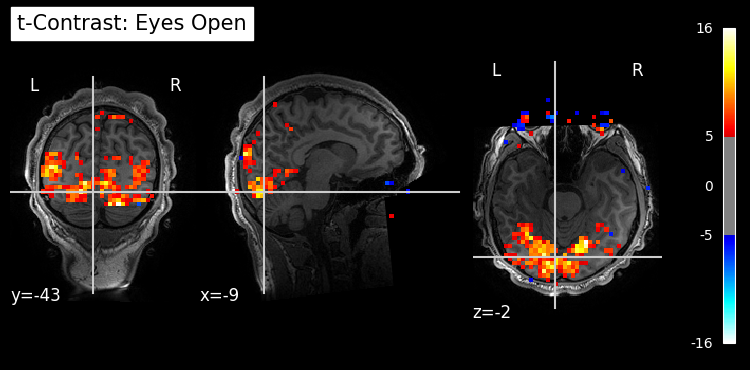

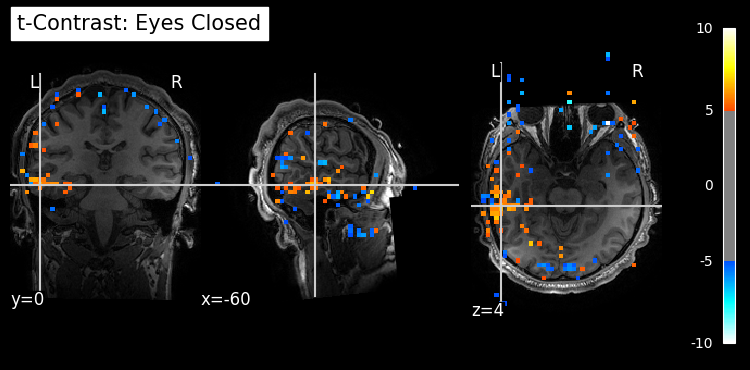

In [16]:
# Create a canonical HRF function
from nilearn.glm.first_level.hemodynamic_models import glover_hrf # Import glover_hrf function
from scipy.interpolate import interp1d

TR = 2 # Repetition Time
osf = 2 # Oversampling Factor
length_hrf = 32 # Length of HRF in seconds
canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf,
onset=0) # Assign the resulting glover_hrf with the specified input above to a variable
canonical_hrf /= canonical_hrf.max() # Normalize HRF to have a maximum of one.
print("Size of canonical hrf variable: %i" % canonical_hrf.size) # Print hrf size


# HRF MODEL GENERATION
predictor_all = design_EO # Assign the eyes open vector to predictor_all 
predictor_conv = np.convolve(predictor_all.squeeze(), canonical_hrf) # Convolve the predictor_all vector with the canonical hrf function
# After convolution, we also neem to "trim" off some excess values from the convolved signal
predictor_conv = predictor_conv[:predictor_all.size]
# And we have to add a new axis again to go from shape (N,) to (N, 1), which is important for stacking the intercept, later
predictor_conv = predictor_conv[:, np.newaxis]
original_scale = np.arange(0, 240) # Sample the original time values (seconds)
resampler = interp1d(original_scale, np.squeeze(predictor_conv)) # Resample the time values with the convolved values
desired_scale = np.arange(0, 240, 2) # Half the original time to get time volumes
predictor_conv_ds = resampler(desired_scale) # Apply the resample to get desired scale
predictor_EO_ds = predictor_conv_ds[:, np.newaxis] # Copy predictor and add an extra axis to it

# HRF MODEL GENERATION
predictor_all = design_EC # Assign the eyes open vector to predictor_all 
predictor_conv = np.convolve(predictor_all.squeeze(), canonical_hrf) # Convolve the predictor_all vector with the canonical hrf function
# After convolution, we also neem to "trim" off some excess values from the convolved signal
predictor_conv = predictor_conv[:predictor_all.size]
# And we have to add a new axis again to go from shape (N,) to (N, 1), which is important for stacking the intercept, later
predictor_conv = predictor_conv[:, np.newaxis]
original_scale = np.arange(0, 240) # Sample the original time values (seconds)
resampler = interp1d(original_scale, np.squeeze(predictor_conv)) # Resample the time values with the convolved values
desired_scale = np.arange(0, 240, 2) # Half the original time to get time volumes
predictor_conv_ds = resampler(desired_scale) # Apply the resample to get desired scale
predictor_EC_ds = predictor_conv_ds[:, np.newaxis] # Copy predictor and add an extra axis to it


icept = np.ones((design_EC_downsampled.size, 1)) # Generate template for intercepts

# Combine Eyes Open and Eyes Closed regressors
design_matrix = np.column_stack([icept, predictor_EO_ds, predictor_EC_ds])

# Fit GLM to each voxel
data = img.get_fdata()
shape = data.shape[:-1]  # Exclude time dimension
beta_maps = np.zeros((*shape, 3))  # Now accounting for three predictors

for x in range(shape[0]): # Loop through x axis
    for y in range(shape[1]): # Loop through y axis
        for z in range(shape[2]): # Loop through z axis
            voxel_signal = data[x, y, z, :] # Grab voxel signal
            if np.any(voxel_signal): # Check if the voxel signal is valid
                betas_simple = np.linalg.inv(design_matrix.T @ design_matrix) @ design_matrix.T @ voxel_signal # Calculate the betas for the simple model
                beta_maps[x, y, z, :] = betas_simple # Put the betas into same voxel position

# Contrasts
contrast_EO = np.array([0, 1, 0])
contrast_EC = np.array([0, 0, 1])

# Compute t-maps
t_map_EO = np.zeros(shape)
t_map_EC = np.zeros(shape)


for x in range(shape[0]): # Loop through x axis
    for y in range(shape[1]): # Loop through y axis
        for z in range(shape[2]): # Loop through z axis
            beta = beta_maps[x, y, z, :] # Grab beta vector for a given voxel
            residual_var = np.sum((data[x, y, z, :] - design_matrix @ beta) ** 2) / (design_matrix.shape[0] - design_matrix.shape[1]) # Calculate the variance sum
            var_beta = np.linalg.inv(design_matrix.T @ design_matrix).diagonal() # Calculate the variance of the beta vector
            t_map_EO[x, y, z] = (contrast_EO @ beta) / np.sqrt(residual_var * (contrast_EO @ np.linalg.inv(design_matrix.T @ design_matrix) @ contrast_EO)) # Get t-test result for eyes open
            t_map_EC[x, y, z] = (contrast_EC @ beta) / np.sqrt(residual_var * (contrast_EC @ np.linalg.inv(design_matrix.T @ design_matrix) @ contrast_EC)) # Get t-test result for eyes closed

# Create statistical maps
t_map_EO_img = new_img_like(img, t_map_EO) # Make map with t-tests of eyes open
t_map_EC_img = new_img_like(img, t_map_EC) # Make map with t-tests of eyes closed

# Plot
plot_stat_map(t_map_EO_img, bg_img=background_img, title="t-Contrast: Eyes Open", threshold=5.0, dim=-0.5) # Plot the Eyes Open Map at threshold 5
plot_stat_map(t_map_EC_img, bg_img=background_img, title="t-Contrast: Eyes Closed", threshold=5.0, dim=-0.5) # Plot the Eyes Open Map at threshold 5

From the results above we can see how well our HRF GLMs did and for the most part they did better than the non HRF GLMs.

The first thing to notice is that in the eyes open plot you see a massive positive corralation going on near back of the brain. The signal is extremely bright showing us that our models assumption of higher amplitude of the voxel signal during eyes open events was correct in this back part of the brain. This area looks to be the occipital lobe and makes sense due to general consensus being that the occipital lobe is responsible for visual prossesing. That also maps onto our plot here showing high brain activation in that region when the eyes are open.

And when it comes to the eyes closed plot we see a better corralation than before in that bottom left portion of the brain. Even though the corralation in this plot is not as strong as the eyes open plot, there is still some key things to notice here. This bottem left portion of the brain looks to be the temporal lobe of which general consensus is that the temporal lobe is responsible for memory processing, processing visual information, and other similar functionalities. With that information along with our plot we can assume that potentially this person is processing the image which they just saw in the eyes open phase in the eyes closed phase. However an intresting thing to note is that this signal is mostly on the left hand side and essentially empty on the right.


---

# General Thoughts about All Plots

I think the fact that the non HRF GLM eyes open plot had high negative corralation in the eyes and the HRF GLM eyes open plot had high possitive corralation in the occipital lobe as a strange thing that I didn't expect to happen. Both make sense, but if anything I would have expected one or the other, not both.

Also the fact that you could tell there was a little something going on in the left temporal lobe in the non HRF GLM eyes closed plot was interesting, but still not strong enough to go off of in my opinion and then that corralation being more confidently confirmed by the HRF GLM eyes closed model was neat to see and shows why HRF are very useful in looking at fMRI data.

Overall, I would say that the GLMs were good enough to see good corralations and make good conclutions from that after seeing it applied to all voxel signals in the fMRI data.